In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
import xgboost as xgb
from mealpy import *
import numpy as np
from xgboost import XGBRegressor
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations


In [4]:
df = pd.read_csv("housing.csv")
df_ocean_proximity = df
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# Creamos las variables dummies de la variable ocean_proximity
dummies = pd.get_dummies(df['ocean_proximity'], drop_first=True)

# Concatenamos las variables dummies al dataframe original
df = pd.concat([df, dummies], axis=1)
df.drop("ocean_proximity",axis=1,inplace=True)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False


In [6]:
df.info()
# Comprobamos si hay valores nulos, en este caso no hay

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   INLAND              20640 non-null  bool   
 10  ISLAND              20640 non-null  bool   
 11  NEAR BAY            20640 non-null  bool   
 12  NEAR OCEAN          20640 non-null  bool   
dtypes: bool(4), float64(9)
memory usage: 1.5 MB


<Axes: >

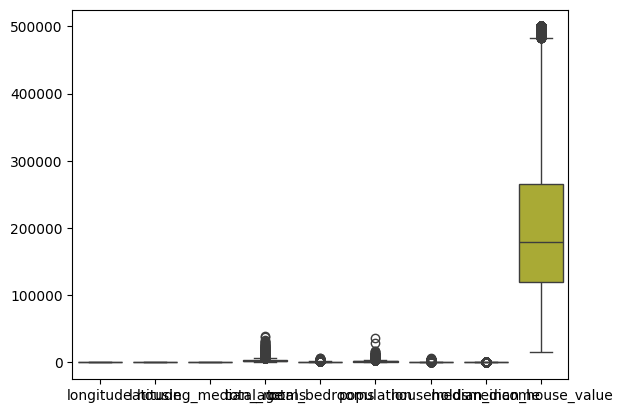

In [7]:

sns.boxplot(data=df_ocean_proximity.drop(columns=['ocean_proximity']))


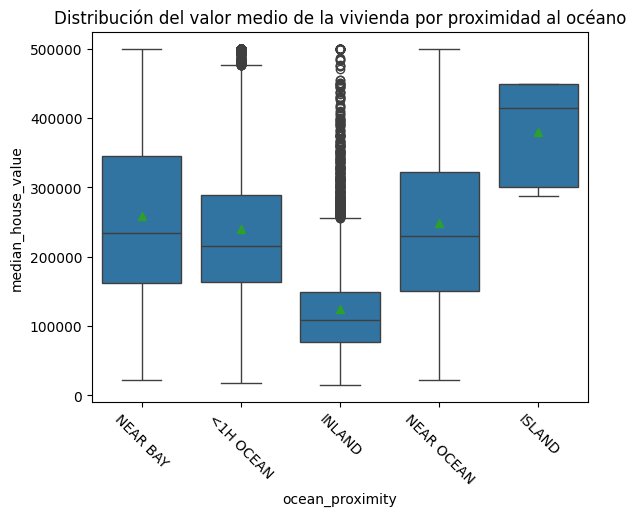

In [8]:
# Create and display a box plot to visualize the distribution of `median_house_value` across different categories of `ocean_proximity`
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df_ocean_proximity, showmeans=True)
plt.title('Distribución del valor medio de la vivienda por proximidad al océano')
plt.xticks(rotation=-45)
plt.show()


**Distribución del valor medio de la vivienda por proximidad al océano**

Este gráfico de caja muestra cómo la proximidad al océano influye en el valor medio de la vivienda. Podemos observar que las viviendas cercanas al océano ('<1H OCEAN' y 'NEAR OCEAN') tienden a tener valores medios más altos en comparación con las del interior ('INLAND'). Además, las viviendas en islas ('ISLAND') tienen el valor medio más alto, aunque el tamaño de la muestra es muy pequeño para generalizar.


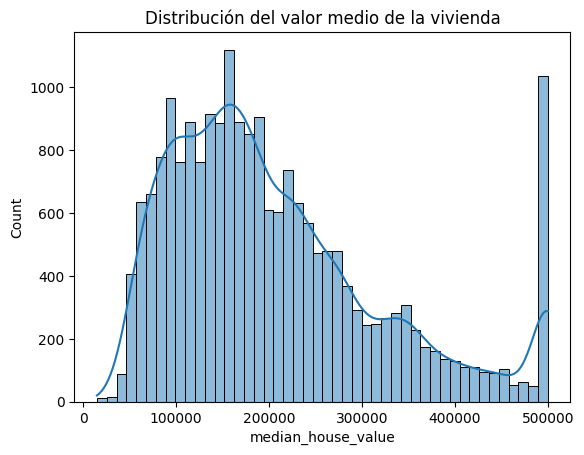

In [9]:

# Histograma de la variable median_house_value para ver su distribución
sns.histplot(df['median_house_value'], kde=True)
plt.title('Distribución del valor medio de la vivienda')
plt.show()



**Distribución del valor medio de la vivienda**

Este histograma ilustra la distribución de los valores medios de las viviendas. La mayoría de las viviendas tienen un valor medio por debajo de 500,000, con una cola derecha que indica la presencia de algunas viviendas con valores significativamente más altos.
"""

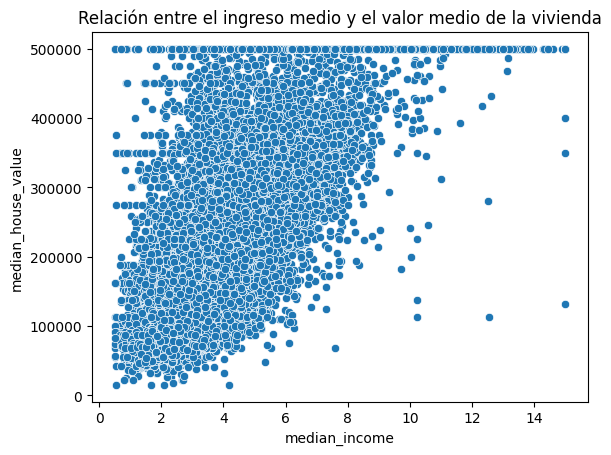

In [10]:
# Scatter plot de la variable median_income y median_house_value
sns.scatterplot(x='median_income', y='median_house_value', data=df)
plt.title('Relación entre el ingreso medio y el valor medio de la vivienda')
plt.show()

**Distribución del valor medio de la vivienda**

Este histograma ilustra la distribución de los valores medios de las viviendas. La mayoría de las viviendas tienen un valor medio por debajo de 500,000, con una cola derecha que indica la presencia de algunas viviendas con valores significativamente más altos.


In [11]:

# Split the data into features and target variable
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
  # O cualquier otra métrica de regresión relevante

# 1. Definir el modelo XGBoost para regresión
model = xgb.XGBRegressor(tree_method='hist',device='cuda')

# 2. Definir la grilla de hiperparámetros a probar (ajustada para regresión)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],  # Controla el porcentaje de muestras usadas en cada árbol
    'colsample_bytree': [0.8, 1.0]  # Controla el porcentaje de características usadas en cada árbol
}

# 3. Crear el objeto GridSearchCV (usando una métrica de regresión)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# 4. Entrenar y afinar (usando tus datos ya divididos)
grid_search.fit(X_train, y_train)

# 5. Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


/home/mendi/anaconda3/envs/IO/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/mendi/anaconda3/envs/IO/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in

In [13]:

# Calcular RMSE en el conjunto de prueba
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
print(r2)
print(rmse)

0.84990110775364
44240.500265781186


/home/mendi/anaconda3/envs/IO/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:11:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


# Optimización con Mealpy con BaseGA

In [14]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mealpy import Problem
from mealpy import IntegerVar, FloatVar
from mealpy.evolutionary_based.GA import BaseGA

# Asume que df es tu DataFrame
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Definimos la clase de optimización, almacenando los métodos de nuestro problema
class OptimizeXGB(Problem):
    def __init__(self, bounds=None, minmax="min", name=None, data=None, **kwargs):
        self.name = name
        self.data = data
        super().__init__(bounds, minmax, **kwargs)

    # Función a optimizar
    def obj_func(self, pars):
        # pars es una lista de valores, necesitamos construir un diccionario con las claves correctas
        param_dict = {
            'lr': pars[0],
            'n_estimators': int(pars[1]),  # n_estimators debe ser un entero
            'max_depth': int(pars[2]),     # max_depth también debe ser un entero
            'subsample': pars[3],
            'colsample_bytree': pars[4]
        }

        # Definimos el regresor XGBoost, cambiando sus hiperparámetros predeterminados según sea necesario
        xgb_model = xgb.XGBRegressor(
            learning_rate=param_dict['lr'],
            n_estimators=param_dict['n_estimators'],
            max_depth=param_dict['max_depth'],
            subsample=param_dict['subsample'],
            colsample_bytree=param_dict['colsample_bytree'],
            random_state=135,
            tree_method='hist',
            device='cuda'
        )

        # Ajustamos el modelo a los datos de entrenamiento
        xgb_model.fit(self.data["X_train"], self.data["y_train"])

        # Predicción en datos de prueba
        y_pred = xgb_model.predict(self.data["X_test"])

        # Calculamos el error cuadrático medio
        metric = mean_squared_error(self.data["y_test"], y_pred)

        return metric  # mealpy minimiza por defecto, así que devolvemos el MSE directamente

# Definimos el espacio de hiperparámetros (valores posibles para cada uno)
bounds = [
    FloatVar(lb=0.0001, ub=1.0, name='lr'),
    IntegerVar(lb=25, ub=1000, name='n_estimators'),
    IntegerVar(lb=3, ub=10, name='max_depth'),
    FloatVar(lb=0.5, ub=1.0, name='subsample'),
    FloatVar(lb=0.5, ub=1.0, name='colsample_bytree'),
]

# Preparamos los datos
problem_data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
}

# Creamos una instancia de OptimizeXGB. Especificamos bounds, minmax ('min' para minimizar el error) y nombre
problem = OptimizeXGB(bounds=bounds, minmax="min", name='BaseGA', data=problem_data)

# Elegimos el algoritmo metaheurístico (en este caso BaseGA)
ga_model = BaseGA(epoch=3, pop_size=10, pc=0.8, pm=0.1)

# Ejecutamos la optimización y obtenemos el mejor agente
best_agent = ga_model.solve(problem)

# Accedemos a los mejores hiperparámetros y la mejor aptitud directamente del objeto Agent
best_solution = best_agent.solution

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", best_solution)

# Evaluamos el mejor modelo en tus datos de prueba
best_model = xgb.XGBRegressor(
    learning_rate=best_solution[0],  # lr
    n_estimators=int(best_solution[1]),  # n_estimators
    max_depth=int(best_solution[2]),  # max_depth
    subsample=best_solution[3],  # subsample
    colsample_bytree=best_solution[4],  # colsample_bytree
    random_state=135,
    tree_method='hist',
    device='cuda'
)

# Ajustamos el modelo a los datos de entrenamiento
best_model.fit(X_train, y_train)

# Predicción en datos de prueba
y_pred = best_model.predict(X_test)

# Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = best_model.score(X_test, y_test)

print("RMSE:", rmse)
print("R2 Score:", r2)


2024/09/26 06:11:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.
2024/09/26 06:12:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1977005983.044781, Global best: 1977005983.044781, Runtime: 25.38686 seconds
2024/09/26 06:12:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1956385775.005389, Global best: 1956385775.005389, Runtime: 13.55922 seconds
2024/09/26 06:13:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1977005983.044781, Global best: 1956385775.005389, Runtime: 25.11495 seconds


Mejores hiperparámetros: [1.07366858e-01 5.44000000e+02 9.00000000e+00 8.54160196e-01
 9.28039247e-01]
RMSE: 44231.04989716374
R2 Score: 0.8499652272074426


# # Optimización con Mealpy con PSO

In [13]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from mealpy import Problem
from mealpy import IntegerVar, FloatVar
from mealpy.swarm_based import PSO

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
  # O cualquier otra métrica de regresión relevante # O cualquier otra métrica de regresión relevante


# Definimos la clase de optimización, almacenando los métodos de nuestro problema
class OptimizeXGB(Problem):
    def __init__(self, bounds=None, minmax="min", name=None, data=None, **kwargs):
        self.name = name
        self.data = data
        super().__init__(bounds, minmax, **kwargs)

    # Función a optimizar
    def obj_func(self, pars):
    # pars es una lista de valores, necesitamos construir un diccionario con las claves correctas
        param_dict = {
            'lr': pars[0],
            'n_estimators': int(pars[1]),  # n_estimators debe ser un entero
            'max_depth': int(pars[2]),     # max_depth también debe ser un entero
            'subsample': pars[3],
            'colsample_bytree': pars[4]
        }

        # Definimos el regresor XGBoost, cambiando sus hiperparámetros predeterminados según sea necesario
        xgb_model = xgb.XGBRegressor(
            learning_rate=param_dict['lr'],
            n_estimators=param_dict['n_estimators'],
            max_depth=param_dict['max_depth'],
            subsample=param_dict['subsample'],
            colsample_bytree=param_dict['colsample_bytree'],
            random_state=135,
            tree_method='hist',
            device='cuda'
        )

        # Ajustamos el modelo a los datos de entrenamiento
        xgb_model.fit(self.data["X_train"], self.data["y_train"])

        # Predicción en datos de prueba
        y_pred = xgb_model.predict(self.data["X_test"])

        # Calculamos el error cuadrático medio
        metric = mean_squared_error(self.data["y_test"], y_pred)

        return metric  # mealpy minimiza por defecto, así que devolvemos el MSE directamente


# Definimos el espacio de hiperparámetros (valores posibles para cada uno)
bounds = [
    FloatVar(lb=0.0001, ub=1.0, name='lr'),
    IntegerVar(lb=25, ub=1000, name='n_estimators'),
    IntegerVar(lb=3, ub=10, name='max_depth'),
    FloatVar(lb=0.5, ub=1.0, name='subsample'),
    FloatVar(lb=0.5, ub=1.0, name='colsample_bytree'),
]

# Preparamos los datos
problem_data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
}

# Creamos una instancia de OptimizeXGB. Especificamos bounds, minmax ('min' para minimizar el error) y nombre
problem = OptimizeXGB(bounds=bounds, minmax="min", name='PSO', data=problem_data)

# Elegimos el algoritmo metaheurístico (en este caso PSO)
meta_model = PSO.OriginalPSO(epoch=3, pop_size=10)

# Ejecutamos la optimización
best_agent = meta_model.solve(problem)

# Accedemos a los mejores hiperparámetros y la mejor aptitud directamente del objeto Agent
best_solution = best_agent.solution

#best_fitness = best_agent.objective_value

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", best_solution)
#print("Mejor MSE:", best_fitness)

# Evaluamos el mejor modelo en tus datos de prueba
best_model = xgb.XGBRegressor(
    learning_rate=best_solution[0],  # lr
    n_estimators=int(best_solution[1]),  # n_estimators
    max_depth=int(best_solution[2]),  # max_depth
    subsample=best_solution[3],  # subsample
    colsample_bytree=best_solution[4],  # colsample_bytree
    random_state=135,
    tree_method='hist',
    device='cuda'
)

# Ajustamos el modelo a los datos de entrenamiento
best_model.fit(X_train, y_train)

# Predicción en datos de prueba
y_pred = best_model.predict(X_test)

# Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # mean_squared_error es el nombre correcto
r2 = best_model.score(X_test, y_test)

print("RMSE:", rmse)
print("R2 Score:", r2)


2024/09/18 01:02:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.
2024/09/18 01:03:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2234752343.8466325, Global best: 2234752343.8466325, Runtime: 14.85915 seconds
2024/09/18 01:03:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2195351583.8319063, Global best: 2195351583.8319063, Runtime: 12.69850 seconds
2024/09/18 01:03:56 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2017003053.1026206, Global best: 2017003053.1026206, Runtime: 28.16979 seconds


Mejores hiperparámetros: [1.42195599e-01 3.88538827e+02 8.62400913e+00 6.43764938e-01
 7.52962185e-01]
RMSE: 44911.05713632914
R2 Score: 0.8453165021641437


# Optimizacion multivariable


In [14]:
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
  # O cualquier otra métrica de regresión relevante

class XGBHyperparameterOptimization(FloatProblem):

    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__()

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Definir los límites de los hiperparámetros
        self.lower_bound = [0.01, 100, 3, 0.5, 0.5]  # learning_rate, n_estimators, max_depth, subsample, colsample_bytree
        self.upper_bound = [0.5, 2000, 20, 1.0, 1.0]  # Aumentar el rango superior

        self._number_of_variables = 5  # Número de hiperparámetros
        self._number_of_objectives = 2  # Minimizar RMSE y maximizar R²
        self._number_of_constraints = 0
        
        # Direcciones de optimización: minimizar RMSE y maximizar R²
        self.obj_directions = [self.MINIMIZE, self.MAXIMIZE]

    def create_solution(self) -> FloatSolution:
        solution = FloatSolution(
            lower_bound=self.lower_bound,
            upper_bound=self.upper_bound,
            number_of_objectives=self.number_of_objectives
        )
        solution.variables = [np.random.uniform(lb, ub) for lb, ub in zip(self.lower_bound, self.upper_bound)]
        return solution

    def evaluate(self, solution: FloatSolution):
        # Extraer los valores de los hiperparámetros de la solución
        learning_rate = solution.variables[0]
        n_estimators = int(solution.variables[1])
        max_depth = int(solution.variables[2])
        subsample = solution.variables[3]
        colsample_bytree = solution.variables[4]

        # Definir el modelo XGBoost con los hiperparámetros
        model = XGBRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            device='cuda'
        )

        # Entrenar el modelo
        model.fit(self.X_train, self.y_train)

        # Hacer predicciones
        predictions = model.predict(self.X_test)

        # Calcular RMSE y R²
        rmse = np.sqrt(mean_squared_error(self.y_test, predictions))
        r2 = r2_score(self.y_test, predictions)

        # Almacenar los objetivos: minimizar RMSE y maximizar R²
        solution.objectives[0] = rmse
        solution.objectives[1] = r2

    @property
    def name(self):
        return 'XGBHyperparameterOptimization'

    @property
    def number_of_variables(self):
        return self._number_of_variables

    @property
    def number_of_objectives(self):
        return self._number_of_objectives

    @property
    def number_of_constraints(self):
        return self._number_of_constraints

# Crear el problema de optimización
problem = XGBHyperparameterOptimization(X_train, X_test, y_train, y_test)

# Configurar el algoritmo NSGA-II
algorithm = NSGAII(
    problem=problem,
    population_size=10,  # Aumentamos la población
    offspring_population_size=10,
    mutation=PolynomialMutation(probability=1.0/problem.number_of_variables, distribution_index=20),
    crossover=SBXCrossover(probability=0.9, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations=10)  # Aumentamos el número de evaluaciones
)

# Ejecutar el algoritmo
algorithm.run()



[2024-09-18 13:03:58,968] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-09-18 13:03:58,969] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-09-18 13:09:37,558] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-09-18 13:09:37,558] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-09-18 13:09:37,559] [jmetal.core.algorithm] [DEBUG] Finished!


In [15]:
solutions = algorithm.result()
print(solutions)

[<jmetal.core.solution.FloatSolution object at 0x7f6000a67080>, <jmetal.core.solution.FloatSolution object at 0x7f6000b81df0>, <jmetal.core.solution.FloatSolution object at 0x7f6000a31640>, <jmetal.core.solution.FloatSolution object at 0x7f60007e6690>, <jmetal.core.solution.FloatSolution object at 0x7f6000ad97c0>, <jmetal.core.solution.FloatSolution object at 0x7f6000ad9a90>, <jmetal.core.solution.FloatSolution object at 0x7f6000ad8ad0>, <jmetal.core.solution.FloatSolution object at 0x7f6000ad95b0>, <jmetal.core.solution.FloatSolution object at 0x7f6000ada780>, <jmetal.core.solution.FloatSolution object at 0x7f6000ada510>]


Solución 1:
  - RMSE: 47420.3996396793
  - R²: 0.8275481538514085
  - Hiperparámetros: [0.06502451246177186, 364.30693083268574, 19.169575759514167, 0.7985625701052319, 0.51218201075877]
Solución 2:
  - RMSE: 47933.072367269495
  - R²: 0.8237991649490916
  - Hiperparámetros: [0.19968797000598576, 1521.8898692914863, 15.820170900584493, 0.8963633700641995, 0.5295264840126501]
Solución 3:
  - RMSE: 46627.363695796215
  - R²: 0.8332679265701153
  - Hiperparámetros: [0.034043392924604905, 751.9387359282874, 17.816055681264316, 0.902581119535681, 0.5194878320154326]
Solución 4:
  - RMSE: 55144.603095689454
  - R²: 0.7667919921783433
  - Hiperparámetros: [0.3843144156590962, 858.2746613296432, 19.544296139509267, 0.9189697961742245, 0.5451752100083099]
Solución 5:
  - RMSE: 46690.78053023027
  - R²: 0.8328140810198152
  - Hiperparámetros: [0.18583220993142274, 779.4801754646114, 3.524679970613477, 0.75176046014952, 0.5003839657076552]
Solución 6:
  - RMSE: 46680.178487074845
  - R²: 0.832889

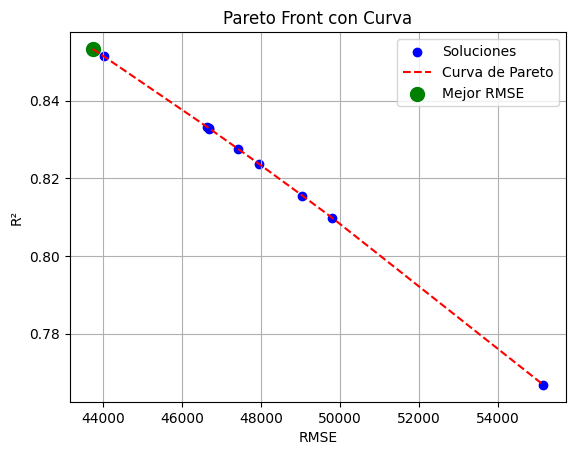

In [16]:
solutions = algorithm.result()

# Imprimir los valores de las soluciones
for i, solution in enumerate(solutions):
    print(f"Solución {i + 1}:")
    print(f"  - RMSE: {solution.objectives[0]}")
    print(f"  - R²: {solution.objectives[1]}")
    print(f"  - Hiperparámetros: {solution.variables}")

# Extraer los objetivos de las soluciones para el gráfico de Pareto
pareto_front = [[solution.objectives[0], solution.objectives[1]] for solution in solutions]

# Convertir la lista en dos listas separadas para RMSE y R²
rmse_values = [point[0] for point in pareto_front]
r2_values = [point[1] for point in pareto_front]

# Crear el gráfico de Pareto
plt.scatter(rmse_values, r2_values, label='Soluciones', color='blue')

# Ordenar los puntos por RMSE para conectar la curva de Pareto
sorted_pareto = sorted(pareto_front, key=lambda x: x[0])  # Ordenar por RMSE
rmse_pareto = [point[0] for point in sorted_pareto]
r2_pareto = [point[1] for point in sorted_pareto]

# Dibujar la curva de Pareto
plt.plot(rmse_pareto, r2_pareto, label='Curva de Pareto', color='red', linestyle='--')

# Resaltar el mejor punto (por ejemplo, el de mejor RMSE)
best_rmse_index = np.argmin(rmse_values)
plt.scatter(rmse_values[best_rmse_index], r2_values[best_rmse_index], color='green', label='Mejor RMSE', s=100)

# Título y etiquetas del gráfico
plt.title('Pareto Front con Curva')
plt.xlabel('RMSE')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.show()